In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/class_map_corrected.csv
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_multi_diacritics.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet


In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import ReduceLROnPlateau
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/class_map_corrected.csv
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_multi_diacritics.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet


In [3]:
train_df_ = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
test_df_ = pd.read_csv('/kaggle/input/bengaliai-cv19/test.csv')
class_map_df = pd.read_csv('/kaggle/input/bengaliai-cv19/class_map.csv')
sample_sub_df = pd.read_csv('/kaggle/input/bengaliai-cv19/sample_submission.csv')

**Exploratory Data Analysis**

In [39]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('/kaggle/input/kalpurush-fonts/kalpurush-2.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

In [28]:
print(f'Number of unique grapheme roots: {train_df_["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df_["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df_["consonant_diacritic"].nunique()}')

Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


In [44]:
top_10_roots = get_n(train_df_, 'grapheme_root', 5)
top_10_roots

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149


In [45]:
top_5_vowels = get_n(train_df_, 'vowel_diacritic', 5)
top_5_vowels

,index,component,count
0,168,0,41508
1,169,া,36886
7,175,ে,28723
2,170,ি,25967
4,172,ু,18848


In [46]:
top_5_consonants = get_n(train_df_, 'consonant_diacritic', 5)
top_5_consonants

,index,component,count
0,179,0,125278
2,181,র্,23465
5,184,্র,21397
4,183,্য,21270
1,180,ঁ,7424


In [4]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')


Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


In [5]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

In [6]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [7]:
def identity_block(X, f, filters, stage, block):
    """
    ResNet Identity block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape the CONV's window for the main path
    filters -- an integer defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    
    Source kernel : Bengali Graphemes_ Multi Output ResNet-50. 
    The block was modified to correspond to ResNet18 Architecture.
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filter 
       
    F = filters

    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X

    # Component of main path
    X = Conv2D(filters=F, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [8]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- an integer specifying the shape of the middle CONV's window for the main path
    filters -- an integer defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    
    Source kernel : Bengali Graphemes_ Multi Output ResNet-50. 
    The block was modified to correspond to ResNet18 Architecture.
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters     
    F = filters

    # Save the input value
    X_shortcut = X

    # Second component of main path
    X = Conv2D(filters=F, kernel_size=(f, f), strides=(s, s), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [9]:
def ResNet18(input_shape=(64, 64, 1)):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK1 -> IDBLOCK1 -> CONVBLOCK2 -> IDBLOCK2
    -> CONVBLOCK3 -> IDBLOCK3 -> CONVBLOCK4 -> IDBLOCK4 -> AVGPOOL -> TOPLAYERS

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    
    Source kernel : Bengali Graphemes_ Multi Output ResNet-50. 
    The model was modified to correspond to ResNet18 Architecture.
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f=3, filters=64, stage=2, block='a', s=1)
    X = identity_block(X, 3, 64, stage=2, block='b')

    # Stage 3
    X = convolutional_block(X, f=3, filters=128, stage=3, block='a', s=2)
    X = identity_block(X, 3, 128, stage=3, block='b')

    # Stage 4
    X = convolutional_block(X, f=3, filters=256, stage=4, block='a', s=2)
    X = identity_block(X, 3, 256, stage=4, block='b')

    # Stage 5
    X = X = convolutional_block(X, f=3, filters=512, stage=5, block='a', s=2)
    X = identity_block(X, 3, 512, stage=5, block='b')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layers
    X = Flatten()(X)
    head_root = Dense(168, activation = 'softmax', kernel_initializer=glorot_uniform(seed=0))(X)
    head_vowel = Dense(11, activation = 'softmax', kernel_initializer=glorot_uniform(seed=0))(X)
    head_consonant = Dense(7, activation = 'softmax', kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=[head_root, head_vowel, head_consonant], name='ResNet18')

    return model

In [10]:
model = ResNet18(input_shape=(64, 64, 1))

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [14]:
IMG_SIZE=64
N_CHANNELS=1
batch_size = 512
epochs = 20

In [15]:
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_1_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_2_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, 
                                                              restore_best_weights=True, mode="min")  

In [17]:
def get_rand_bbox(width, height, l):
    r_x = np.random.randint(width)
    r_y = np.random.randint(height)
    r_l = np.sqrt(1 - l)
    r_w = np.int(width * r_l)
    r_h = np.int(height * r_l)
    return r_x, r_y, r_l, r_w, r_h

# custom image data generator
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):
    # custom image generator
    def __init__(self, featurewise_center = False, samplewise_center = False, 
                 featurewise_std_normalization = False, samplewise_std_normalization = False, 
                 zca_whitening = False, zca_epsilon = 1e-06, rotation_range = 0.0, width_shift_range = 0.0, 
                 height_shift_range = 0.0, brightness_range = None, shear_range = 0.0, zoom_range = 0.0, 
                 channel_shift_range = 0.0, fill_mode = 'nearest', cval = 0.0, horizontal_flip = False, 
                 vertical_flip = False, rescale = None, preprocessing_function = None, data_format = None, validation_split = 0.0, 
                 mix_up_alpha = 0.0, cutmix_alpha = 0.0): # additional class argument
    
        # parent's constructor
        super().__init__(featurewise_center, samplewise_center, featurewise_std_normalization, samplewise_std_normalization, 
                         zca_whitening, zca_epsilon, rotation_range, width_shift_range, height_shift_range, brightness_range, 
                         shear_range, zoom_range, channel_shift_range, fill_mode, cval, horizontal_flip, vertical_flip, rescale, 
                         preprocessing_function, data_format, validation_split)

        # Mix-up
        assert mix_up_alpha >= 0.0
        self.mix_up_alpha = mix_up_alpha
        
        # Cutmix
        assert cutmix_alpha >= 0.0
        self.cutmix_alpha = cutmix_alpha

    def mix_up(self, X1, y1, X2, y2, ordered_outputs, target_lengths):
        assert X1.shape[0] == y1.shape[0] == X2.shape[0] == y2.shape[0]
        batch_size = X1.shape[0]
        l = np.random.beta(self.mix_up_alpha, self.mix_up_alpha, batch_size)
        X_l = l.reshape(batch_size, 1, 1, 1)
        y_l = l.reshape(batch_size, 1)
        X = X1 * X_l + X2 * (1-X_l)
        target_dict = {}
        i = 0
        for output in ordered_outputs:
            target_length = target_lengths[output]
            target_dict[output] = y1[:, i: i + target_length] * y_l + y2[:, i: i + target_length] * (1 - y_l)
            i += target_length
        y = None
        for output, target in target_dict.items():
            if y is None:
                y = target
            else:
                y = np.concatenate((y, target), axis=1)
        return X, y
    
    def cutmix(self, X1, y1, X2, y2, ordered_outputs, target_lengths):
        assert X1.shape[0] == y1.shape[0] == X2.shape[0] == y2.shape[0]
        lam = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)
        width = X1.shape[1]
        height = X1.shape[0]
        r_x, r_y, r_l, r_w, r_h = get_rand_bbox(width, height, lam)
        bx1 = np.clip(r_x - r_w // 2, 0, width)
        by1 = np.clip(r_y - r_h // 2, 0, height)
        bx2 = np.clip(r_x + r_w // 2, 0, width)
        by2 = np.clip(r_y + r_h // 2, 0, height)
        X1[:, bx1:bx2, by1:by2, :] = X2[:, bx1:bx2, by1:by2, :]
        X = X1
        target_dict = {}
        i = 0
        for output in ordered_outputs:
            target_length = target_lengths[output]
            target_dict[output] = y1[:, i: i + target_length] * lam + y2[:, i: i + target_length] * (1 - lam)
            i += target_length
        y = None
        for output, target in target_dict.items():
            if y is None:
                y = target
            else:
                y = np.concatenate((y, target), axis=1)
        return X, y
    
    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):
        
        # for multi-outputs
        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)
        
        # parent flow
        batches = super().flow(x, targets, batch_size, shuffle, sample_weight, seed, save_to_dir, save_prefix, save_format, subset)
        
        # custom processing
        while True:
            batch_x, batch_y = next(batches)
            
            # mixup or cutmix
            if (self.mix_up_alpha > 0) & (self.cutmix_alpha > 0):
                while True:
                    batch_x_2, batch_y_2 = next(batches)
                    m1, m2 = batch_x.shape[0], batch_x_2.shape[0]
                    if m1 < m2:
                        batch_x_2 = batch_x_2[:m1]
                        batch_y_2 = batch_y_2[:m1]
                        break
                    elif m1 == m2:
                        break
                if np.random.rand() < 0.5:
                    batch_x, batch_y = self.mix_up(batch_x, batch_y, batch_x_2, batch_y_2, ordered_outputs, target_lengths)
                else:
                    batch_x, batch_y = self.cutmix(batch_x, batch_y, batch_x_2, batch_y_2, ordered_outputs, target_lengths)
            
                target_dict = {}
                i = 0
                for output in ordered_outputs:
                    target_length = target_lengths[output]
                    target_dict[output] = batch_y[:, i: i + target_length]
                    i += target_length
                    
                yield batch_x, target_dict

In [18]:
HEIGHT = 137
WIDTH = 236

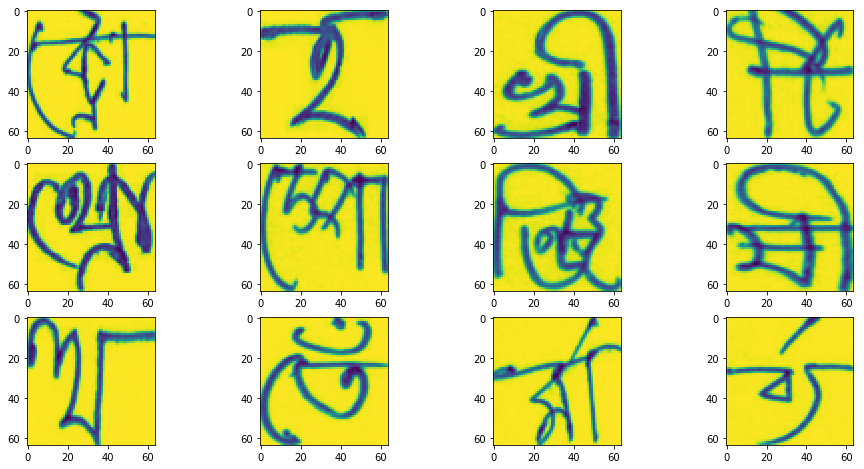


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/20
90/90 [==============================] - 34s 383ms/step - loss: 6.2847 - dense_1_loss: 4.2894 - dense_2_loss: 1.1623 - dense_3_loss: 0.8330 - dense_1_accuracy: 0.0881 - dense_2_accuracy: 0.6137 - dense_3_accuracy: 0.7130 - val_loss: 4.3401 - val_dense_1_loss: 3.3440 - val_dense_2_loss: 0.5310 - val_dense_3_loss: 0.4654 - val_dense_1_accuracy: 0.1964 - val_dense_2_accuracy: 0.8260 - val_dense_3_accuracy: 0.8407
Epoch 2/20
90/90 [==============================] - 27s 295ms/step - loss: 4.0955 - dense_1_loss: 2.8557 - dense_2_loss: 0.7011 - dense_3_loss: 0.5388 - dense_1_accuracy: 0.2995 - dense_2_accuracy: 0.7643 - dense_3_accuracy: 0.8132 - val_loss: 2.6495 - val_dense_1_loss: 1.9444 - val_dense_2_loss: 0.3756 - val_dense_3_loss: 0.3301 - val_dense_1_accuracy: 0.4762 - val_dense_2_accuracy: 0.8793 - val_dense_3_accuracy: 0.8935
Epoc

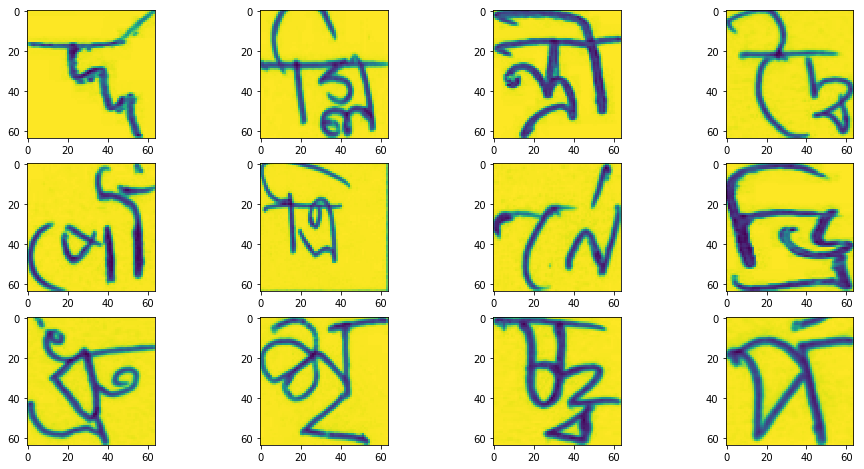


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/20
90/90 [==============================] - 27s 297ms/step - loss: 1.0873 - dense_1_loss: 0.6155 - dense_2_loss: 0.2664 - dense_3_loss: 0.2054 - dense_1_accuracy: 0.8199 - dense_2_accuracy: 0.9151 - dense_3_accuracy: 0.9334 - val_loss: 0.6844 - val_dense_1_loss: 0.4206 - val_dense_2_loss: 0.1425 - val_dense_3_loss: 0.1212 - val_dense_1_accuracy: 0.8720 - val_dense_2_accuracy: 0.9574 - val_dense_3_accuracy: 0.9622
Epoch 2/20
90/90 [==============================] - 26s 293ms/step - loss: 0.9569 - dense_1_loss: 0.5247 - dense_2_loss: 0.2472 - dense_3_loss: 0.1850 - dense_1_accuracy: 0.8445 - dense_2_accuracy: 0.9197 - dense_3_accuracy: 0.9393 - val_loss: 0.6520 - val_dense_1_loss: 0.3940 - val_dense_2_loss: 0.1383 - val_dense_3_loss: 0.1187 - val_dense_1_accuracy: 0.8827 - val_dense_2_accuracy: 0.9579 - val_dense_3_accuracy: 0.9642
Epoc

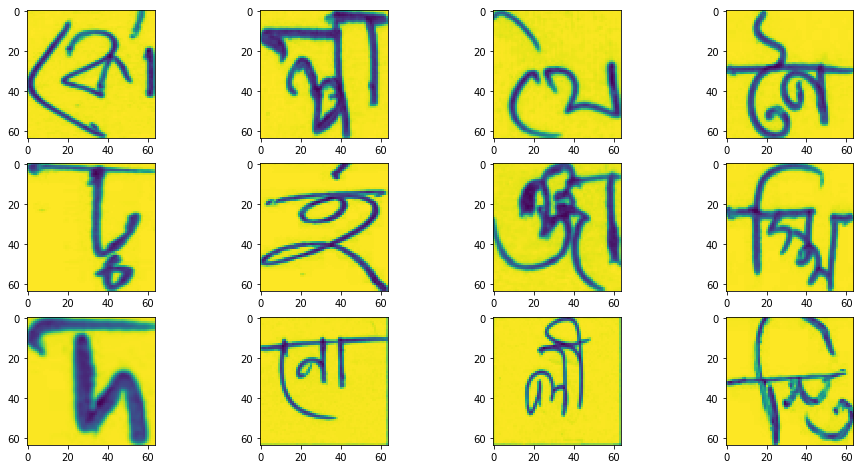


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/20
90/90 [==============================] - 26s 289ms/step - loss: 0.8828 - dense_1_loss: 0.4913 - dense_2_loss: 0.2236 - dense_3_loss: 0.1679 - dense_1_accuracy: 0.8567 - dense_2_accuracy: 0.9294 - dense_3_accuracy: 0.9451 - val_loss: 0.5810 - val_dense_1_loss: 0.3599 - val_dense_2_loss: 0.1107 - val_dense_3_loss: 0.1103 - val_dense_1_accuracy: 0.8942 - val_dense_2_accuracy: 0.9696 - val_dense_3_accuracy: 0.9659
Epoch 2/20
90/90 [==============================] - 26s 290ms/step - loss: 0.7795 - dense_1_loss: 0.4227 - dense_2_loss: 0.2023 - dense_3_loss: 0.1545 - dense_1_accuracy: 0.8728 - dense_2_accuracy: 0.9368 - dense_3_accuracy: 0.9501 - val_loss: 0.5562 - val_dense_1_loss: 0.3343 - val_dense_2_loss: 0.1128 - val_dense_3_loss: 0.1078 - val_dense_1_accuracy: 0.9029 - val_dense_2_accuracy: 0.9701 - val_dense_3_accuracy: 0.9696
Epoc

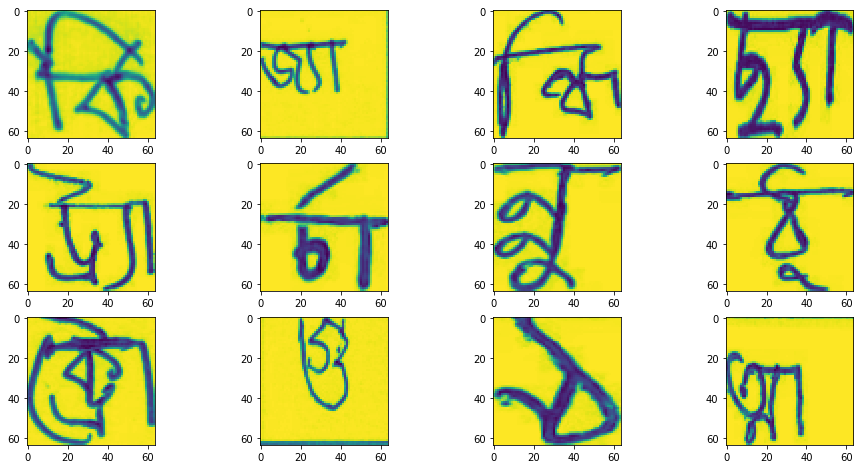


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/20
90/90 [==============================] - 26s 294ms/step - loss: 0.6685 - dense_1_loss: 0.3707 - dense_2_loss: 0.1687 - dense_3_loss: 0.1291 - dense_1_accuracy: 0.8948 - dense_2_accuracy: 0.9474 - dense_3_accuracy: 0.9593 - val_loss: 0.4544 - val_dense_1_loss: 0.2676 - val_dense_2_loss: 0.1049 - val_dense_3_loss: 0.0802 - val_dense_1_accuracy: 0.9218 - val_dense_2_accuracy: 0.9711 - val_dense_3_accuracy: 0.9759
Epoch 2/20
90/90 [==============================] - 25s 278ms/step - loss: 0.6113 - dense_1_loss: 0.3297 - dense_2_loss: 0.1603 - dense_3_loss: 0.1213 - dense_1_accuracy: 0.9019 - dense_2_accuracy: 0.9493 - dense_3_accuracy: 0.9619 - val_loss: 0.4336 - val_dense_1_loss: 0.2542 - val_dense_2_loss: 0.1008 - val_dense_3_loss: 0.0770 - val_dense_1_accuracy: 0.9238 - val_dense_2_accuracy: 0.9726 - val_dense_3_accuracy: 0.9749
Epoc

In [20]:
histories = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'/kaggle/input/bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(64, 64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant
    
    

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=16,  # randomly rotate images in the range (degrees, 0 to 180, was 8)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    mix_up_alpha = 0.4, 
    cutmix_alpha = 0.4)  


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense_1': y_train_root, 'dense_2': y_train_vowel, 'dense_3': y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant, early_stopping_cb])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

In [21]:
%matplotlib inline
def plot_loss(his, title):
    """Function which plots the history of training, in this case the evolution of training and validation loss function.
     
    ARGS : 
    - his : keras history object
    - title : str with title of each plot
    
    OUT :
    - plot of training curve    
    """

    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, len(his.history['loss'])), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, len(his.history['loss'])), his.history['dense_1_loss'], label='train_root_loss')
    plt.plot(np.arange(0, len(his.history['loss'])), his.history['dense_2_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, len(his.history['loss'])), his.history['dense_3_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, len(his.history['loss'])), his.history['val_dense_1_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, len(his.history['loss'])), his.history['val_dense_2_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, len(his.history['loss'])), his.history['val_dense_3_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #/' + str(len(his.history['loss'])))
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, title):
    """Function which plots the history of training, in this case the evolution of training and validation accuracy.
     
    ARGS : 
    - his : keras history object
    - title : str with title of each plot

    OUT :
    - plot of training curve    
    """
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, len(his.history['dense_1_accuracy'])), his.history['dense_1_accuracy'], label='train_root_acc')
    plt.plot(np.arange(0, len(his.history['dense_1_accuracy'])), his.history['dense_2_accuracy'], label='train_vowel_acc')
    plt.plot(np.arange(0, len(his.history['dense_1_accuracy'])), his.history['dense_3_accuracy'], label='train_consonant_acc')
    
    plt.plot(np.arange(0, len(his.history['dense_1_accuracy'])), his.history['val_dense_1_accuracy'], label='val_root_acc')
    plt.plot(np.arange(0, len(his.history['dense_1_accuracy'])), his.history['val_dense_2_accuracy'], label='val_vowel_acc')
    plt.plot(np.arange(0, len(his.history['dense_1_accuracy'])), his.history['val_dense_3_accuracy'], label='val_consonant_acc')
    plt.title(title)
    plt.xlabel('Epoch # /' + str(len(his.history['dense_1_accuracy'])))
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

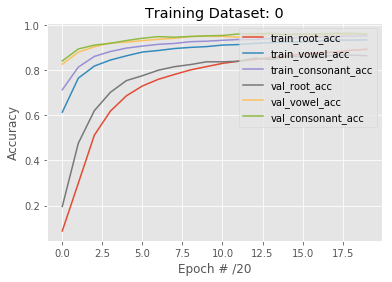

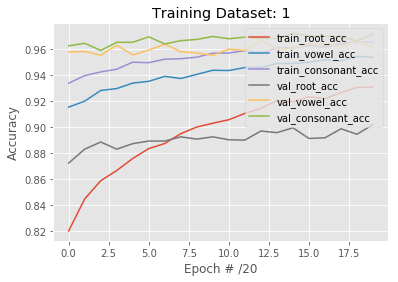

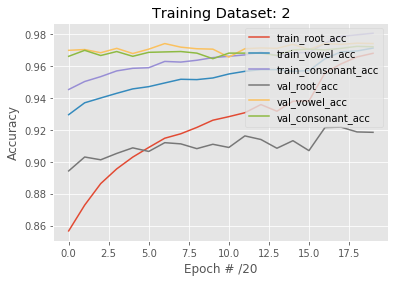

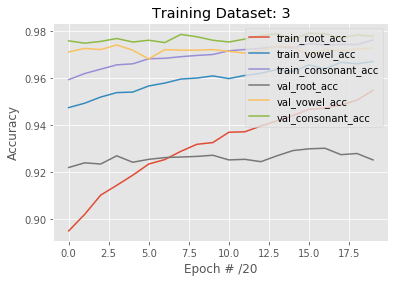

In [23]:
for dataset in range(4):
    plot_acc(histories[dataset], f'Training Dataset: {dataset}')

In [24]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [26]:
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet('/kaggle/input/bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head(10)

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,1
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
5,Test_1_vowel_diacritic,2
6,Test_2_consonant_diacritic,0
7,Test_2_grapheme_root,19
8,Test_2_vowel_diacritic,0
9,Test_3_consonant_diacritic,0
